In [ ]:
from time import sleep
import random
# allows performing command-line operations from within Python
from subprocess import call, Popen
import warnings
warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore", module="statsmodels")

# import the netgen
# import netgen as ng
import bgNetwork.netgen as ng

i=0
# os.chdir(os.path.join(os.path.expanduser('~'), 'bgNetwork'))
outdir = os.path.join(os.path.expanduser('~'), "bgSims")
if not os.path.isdir(outdir):
    os.mkdir(outdir)

import safariplot as splot
splot.style(theme='safari-day', grid=True, spines=True, fscale=1.6)

In [221]:
def save_and_plot(results, behavdf, cond='bal', savedir='~/cbgt', window=15, Start=200, 
                 trials=[None], getdfs=False):
    
    spikedf = get_firing_rates(results, window=window)
    avgRates = get_mean_firing_rates(spikedf)
    
    if trials[0] is not None:
        for t in trials:
            dftrial = get_single_trial_ratedf(spikedf, t)
            ftrial = plot_spikes(dftrial, start=Start)
            fname = 'rates_{}_trial{}.png'.format(cond, str(t))
            ftrial.savefig(os.path.join(savedir, fname), dpi=500)
        plt.close('all')
    
    favg = plot_spikes(avgRates, start=Start)
    fname = 'rates_{}_avg.png'.format(cond)
    favg.savefig(os.path.join(savedir, fname), dpi=500)
    
    behavdfName = 'bgNet_behavdf_{}.csv'.format(cond)
    spikedfName = 'bgNet_spikedf_alltrials_{}.csv'.format(cond)
    avgRatesName = 'bgNet_spikedf_mean_{}.csv'.format(cond)
    
    behavdf.to_csv(os.path.join(savedir, behavdfName), index=False)
    spikedf.to_csv(os.path.join(savedir, spikedfName), index=False)
    avgRates.to_csv(os.path.join(savedir, avgRatesName), index=False)
    
    if getdfs:
        return spikedf, avgRates

    
def get_single_trial_ratedf(spikedf, trial=0):
    sdf = spikedf[spikedf.trial==trial].T.reset_index(drop=True)
    sdf.columns = sdf.iloc[0, :].values
    sdf = sdf.drop(0)
    sdf = sdf.fillna(np.nan)
    return sdf

def get_mean_firing_rates(spikedf, window=None):
    avgdf = spikedf.groupby(['pop']).mean().iloc[:, 1:].T.reset_index(drop=True)    
    return avgdf 

def get_firing_rates(results, window=None, getavg=False):
    dflist = []
    for i, res in enumerate(results):
        ratedf = res['popfreqs']
        if window is not None:
            ratedf = ratedf.rolling(window).mean()
        ratedf = ratedf.T
        if ratedf.shape[1]==0:
            break
        ratedf.insert(0, 'trial', i)
        dflist.append(ratedf)
    alldf = pd.concat(dflist).reset_index()
    alldf = alldf.rename(columns={'index':'pop'})
    if getavg:
        return get_mean_firing_rates(alldf)
    return alldf



def plot_spikes(df, start=300, nchoices=2, clrs = ['#2876B9', '#67A423']):
    
    f, axes = plt.subplots(2, 5, figsize=(18,7), sharex=True)
    axes = axes.flatten()
    
    if isinstance(df, dict):
        df = df['popfreqs'].values
    
    pops = ['LIP', 'D1STR', 'D2STR', 'STNE', 'GPeP', 'GPi', 'Th']
    LIPb_ix = 1
    M1_ix = 2
    if 'LIPI_0' in df.columns:
        pops.insert(1, 'LIPI_0')
        LIPb_ix += 1
    if 'FSI_0' in df.columns:
        pops.append('FSI_0')
        M1_ix += 1
    if 'GPeA_0' in df.columns:
        pops.append('GPeA_0')
    if 'M1_0_0' in df.columns:
        pops.insert(LIPb_ix, 'M1')
    x = df.loc[start:, 'Time (ms)'].values
    ymax=[]
    for i in range(nchoices):
        choicelabel = ['L', 'R'][i]
        for ii, pop in enumerate(pops):
            ax = axes[ii]
            label = pop.split('_')[0]
            if '_0' in pop:
                y = df.loc[start:, pop].values
                clr = 'k'
            else:
                y = df.loc[start:, '{}_{}_0'.format(pop, i)].values
                clr = clrs[i]
            if i == 0:
                ymax.append([])
            ax.plot(x, y, color=clr, label=choicelabel, linewidth=2)
            ax.set_title(label, fontsize=18)
            ymax[ii].append(np.nanmax(y))
            if axes[ii].is_last_row():
                axes[ii].set_xlabel('Time (ms)')
    upper = [np.nanmax(ym)*1.08 for ym in ymax]
    for i, ymax in enumerate(upper):
        axes[i].set_ylim(0, ymax)
        #xt = np.arange(start, 500, 50)
        #axes[i].set_xticks(xt)
        #axes[i].set_xticklabels(xt)
        axes[i].legend(loc=0)
        if axes[i].is_first_col():
            axes[i].set_ylabel('Firing Rate (Hz)')
    sns.despine()
    return f

def analyze_network_behavior(results):
    
    decisions = []
    for sn in range(sweepcount):
        decisions.append([])
        for result in results[sn]:
            decisions[sn].append(ng.findOutputs(result)['decision made'])

    rt = []    
    choice = []
    acc = []
    for sn in range(sweepcount):
        for decision in decisions[sn]:
            if decision['pathvals'] is None:
                continue 
            elif decision['pathvals'] == [0]:
                choice.append(0)
                acc.append(1)
                rt.append(decision['delay'])
            else:
                choice.append(1)
                acc.append(0)
                rt.append(decision['delay'])
    behav_arr = [np.asarray(arr) for arr in [choice, acc, rt]]
    behavdf = pd.DataFrame(dict(zip(['choice', 'acc', 'rt'], behav_arr)))
    return decisions, behavdf


def run_cbgt_simulations(preset=None, ntrials=1000, savedir='~/cbgt', cond='bal',
                         Start=200, popscale=0.5, BaseStim=[1.6], WrongStim=[3.75], 
                         RightStim=[3.75], Dynamic=[30.0], Choices=2, CxSTR=1.,
                         GPiExtEff=6., STNExtEff=1.65, STNExtFreq=4.7):

    ng.setDirectory(savedir)
    sweepcount = ng.configureSweep(experiment='mc', Start=Start, popscale=popscale,
                                   BaseStim=BaseStim, WrongStim=WrongStim,
                                   RightStim=RightStim, Dynamic=Dynamic,
                                   Choices=Choices, CxSTR=CxSTR, GPiExtEff=GPiExtEff,
                                   STNExtEff=STNExtEff, STNExtFreq=STNExtFreq,
                                   preset=preset)

    ng.compileAndRunSweep(ntrials, 0, sweepcount)
    outdir = ng.getDirectory(); popmax = 0; continueLooking = True
    sleep(5)
    
    while continueLooking:
        fnames = [fn.split('.')[0].split('popfreqs')[-1] for fn in os.listdir(outdir)]
        tlist = np.sort([int(fn) for fn in fnames if fn.isnumeric()])
        if tlist == []: continue
        else: popmax = np.max(tlist)
        if popmax < (ntrials-1):
            continue
            
        results = ng.readAllTrialResults(ntrials,0,sweepcount)
        decisions, behavdf = analyze_network_behavior(results)
        
        if np.all([tinfo['time'] for tinfo in decisions[0]]):
            continueLooking=False
        else:
            continue
        
        behavdf['rt'] = behavdf.rt.values + 200
        behavdf.insert(0, 'cond', cond)
        behavdf.insert(1, 'subj_idx', 1)
        behavdf['response'] = behavdf.acc.values
        
    return results[0], behavdf

In [214]:
# presetHi = [{'cxd': {'src':[0,1],'dest':[0,1],'mult':[1.4, .8]},
#              'cxi': {'src':[0,1],'dest':[0,1],'mult':[.8, 1.4]}}]
# presetMod = [{'cxd': {'src':[0,1],'dest':[0,1],'mult':[1.2, .9]},
#              'cxi': {'src':[0,1],'dest':[0,1],'mult':[.9, 1.2]}}]
# presetBal = [{'cxd': {'src':[0,1],'dest':[0,1],'mult':[1., 1.]},
#               'cxi': {'src':[0,1],'dest':[0,1],'mult':[1., 1.]}}]

presetHi = [{'cxd': {'src':[0,1],'dest':[0,1],'mult':[1.2, .9]},
             'cxi': {'src':[0,1],'dest':[0,1],'mult':[.9, 1.2]}}]
presetMod = [{'cxd': {'src':[0,1],'dest':[0,1],'mult':[1.1, .95]},
             'cxi': {'src':[0,1],'dest':[0,1],'mult':[.95, 1.1]}}]
presetWeak = [{'cxd': {'src':[0,1],'dest':[0,1],'mult':[1.01, .995]},
             'cxi': {'src':[0,1],'dest':[0,1],'mult':[.995, 1.01]}}]
presetBal = [{'cxd': {'src':[0,1],'dest':[0,1],'mult':[1., 1.]},
              'cxi': {'src':[0,1],'dest':[0,1],'mult':[1., 1.]}}]

savedir = os.path.join(_dbpath, 'bgFeb18')
if not os.path.isdir(savedir):
    os.mkdir(savedir)

ntrials=1000

conds = ['bal', 'weak', 'mod', 'hi']
saveBal, saveWeak, saveMod, saveHi = [os.path.join(savedir, c) for c in conds]

# Balanced $^{w_D}/_{w_I}$

In [ ]:
resBal, behavdfBal, spikedfBal = run_cbgt_simulations(preset=presetBal, savedir=saveBal, cond='bal', ntrials=20, Start=200, popscale=0.5, BaseStim=[1.6], WrongStim=[3.75], RightStim=[3.75], Dynamic=[30.0], Choices=2, CxSTR=1., GPiExtEff=6., STNExtEff=1.65, STNExtFreq=4.7)

axes = plot_spikes(spikedfBal, start=200)
f = plt.gcf()
f.savefig(os.path.join(saveBal, 'avg_fr_balanced.png'), dpi=500)
behavdfBal.to_csv(os.path.join(saveBal, 'bgNet_behavdf_bal.csv'), index=False)
avgdfBal.to_csv(os.path.join(saveBal, 'bgNet_spikedf_bal.csv'), index=False)

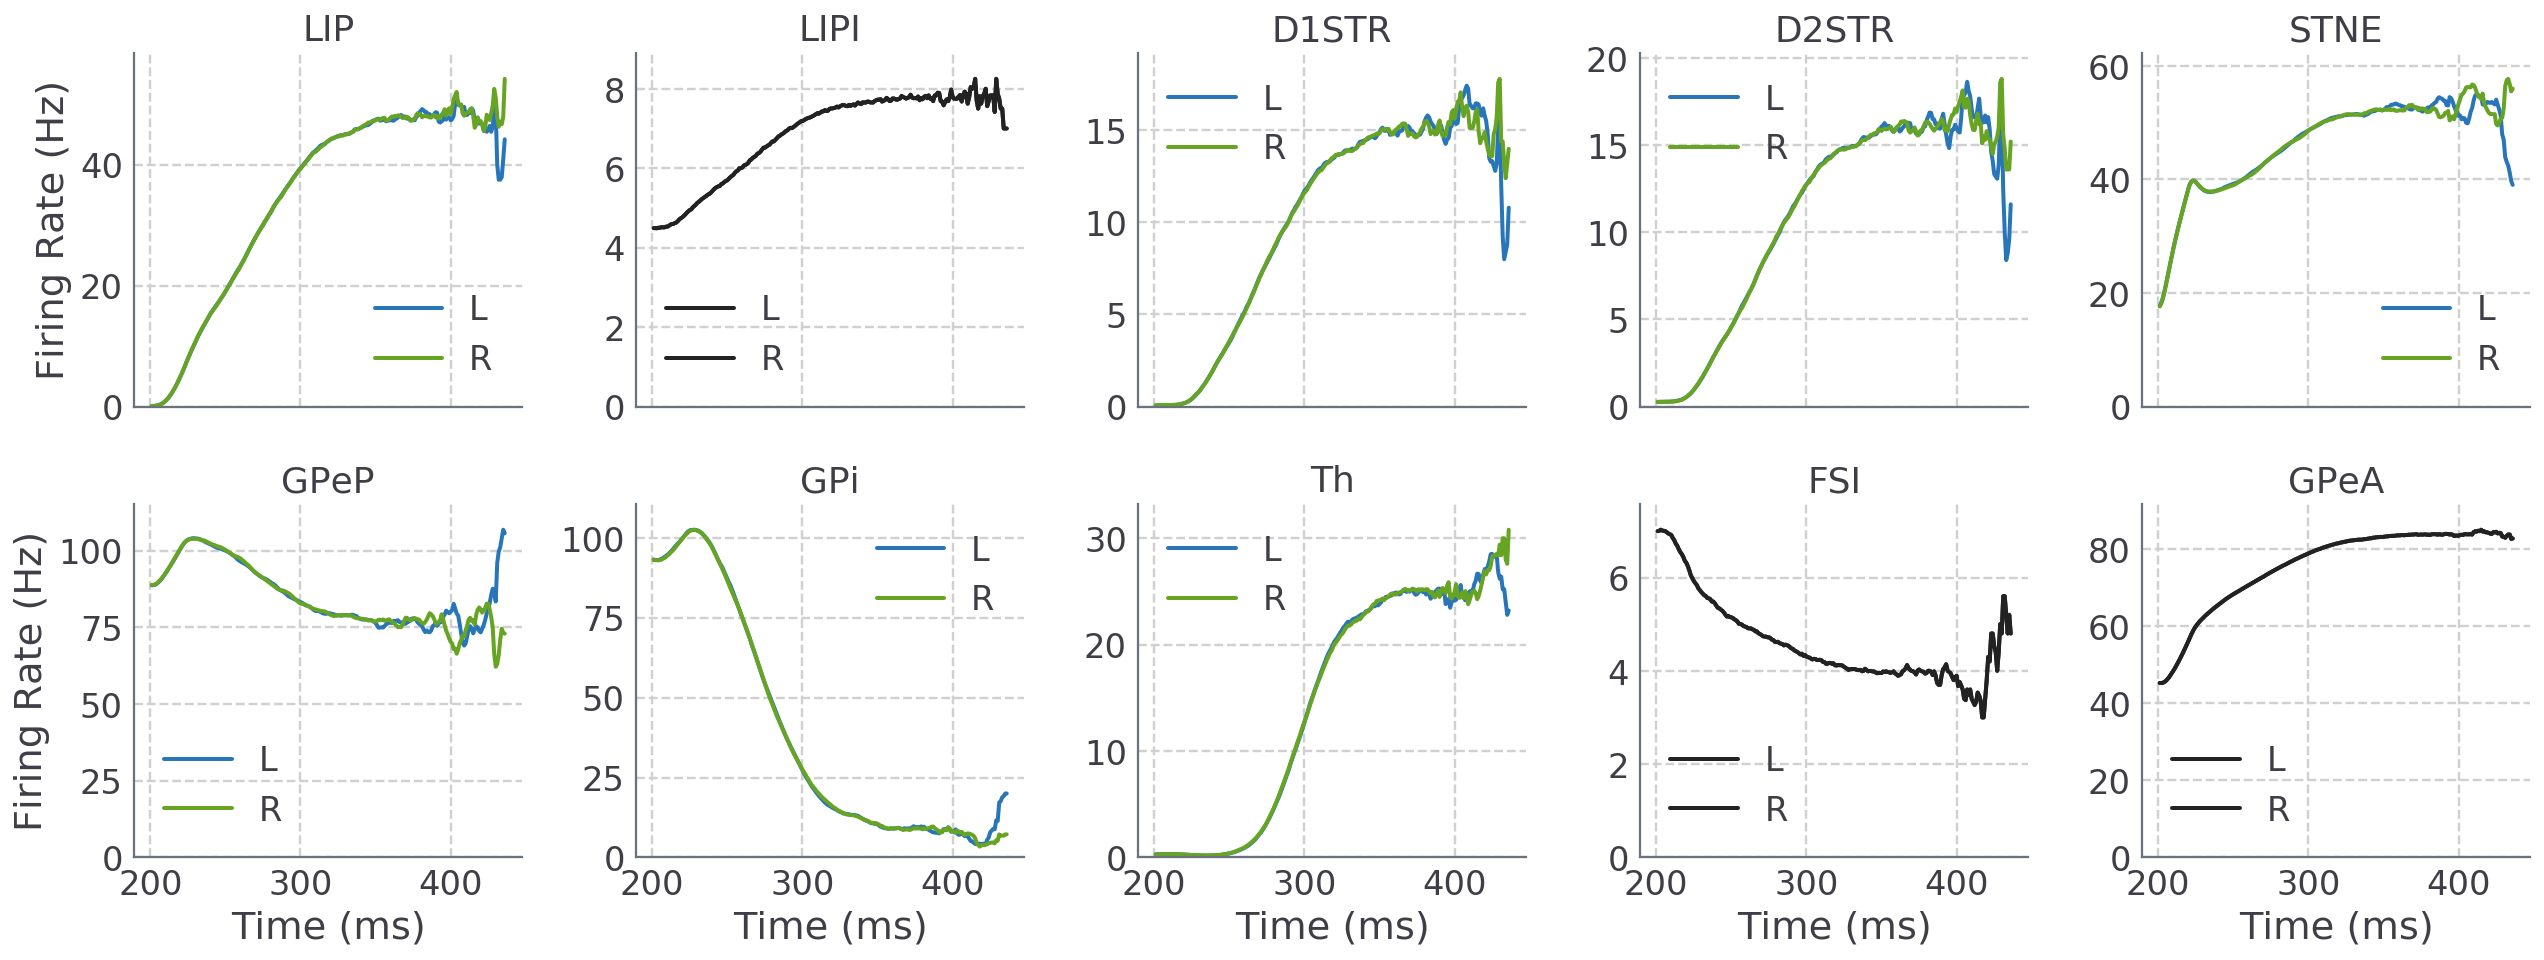

In [5]:
preset = presetBal
ng.setDirectory(saveBal)
sweepcount = ng.configureSweep(preset=presetBal, savedir=saveBal, cond='bal', Start=200, popscale=0.5, BaseStim=[1.6], WrongStim=[3.75], RightStim=[3.75], Dynamic=[30.0], Choices=2, CxSTR=1., GPiExtEff=6., STNExtEff=1.65, STNExtFreq=4.7, preset=presetBal)

ng.compileAndRunSweep(ntrials, 0, sweepcount)
outdir = ng.getDirectory()
popmax = 0
continueLooking = True

sleep(5)
while continueLooking:
    
    fnames = np.asarray([fn.split('.')[0].split('popfreqs')[-1] for fn in os.listdir(outdir)])
    tlist = np.sort([int(fn) for fn in fnames if fn.isnumeric()])
    
    if tlist == []: continue
    else: popmax = np.max(tlist)
        
    if popmax < (ntrials-1):
        continue
    
    resBal = ng.readAllTrialResults(ntrials,0,sweepcount)
    decisionsBal, behavdfBal = analyze_network_behavior(resBal)

    if np.all([tinfo['time'] for tinfo in decisionsBal[0]]):
        continueLooking=False
    else:
        continue
    
    avgdfBal = get_avg_spikedf(resBal[0]).reset_index(drop=True)        
    axes = plot_spikes(avgdfBal, start=200)
    f = plt.gcf()
    f.savefig(os.path.join(savedir, 'avg_fr_balanced.png'), dpi=500)
    behavdfBal['rt'] = behavdfBal.rt.values + 200
    behavdfBal.insert(0, 'cond', 'bal')
    behavdfBal.insert(1, 'subj_idx', 1)
    behavdfBal['response'] = behavdfBal.acc.values
    axes = plot_spikes(avgdfBal, start=200)
    f = plt.gcf()
    f.savefig(os.path.join(savedir, 'avg_fr_balanced.png'), dpi=500)
    behavdfBal.to_csv(os.path.join(savedir, 'bgNet_behavdf_bal.csv'), index=False)
    avgdfBal.to_csv(os.path.join(savedir, 'bgNet_spikedf_bal.csv'), index=False)

# Weak $^{w_D}/_{w_I}$

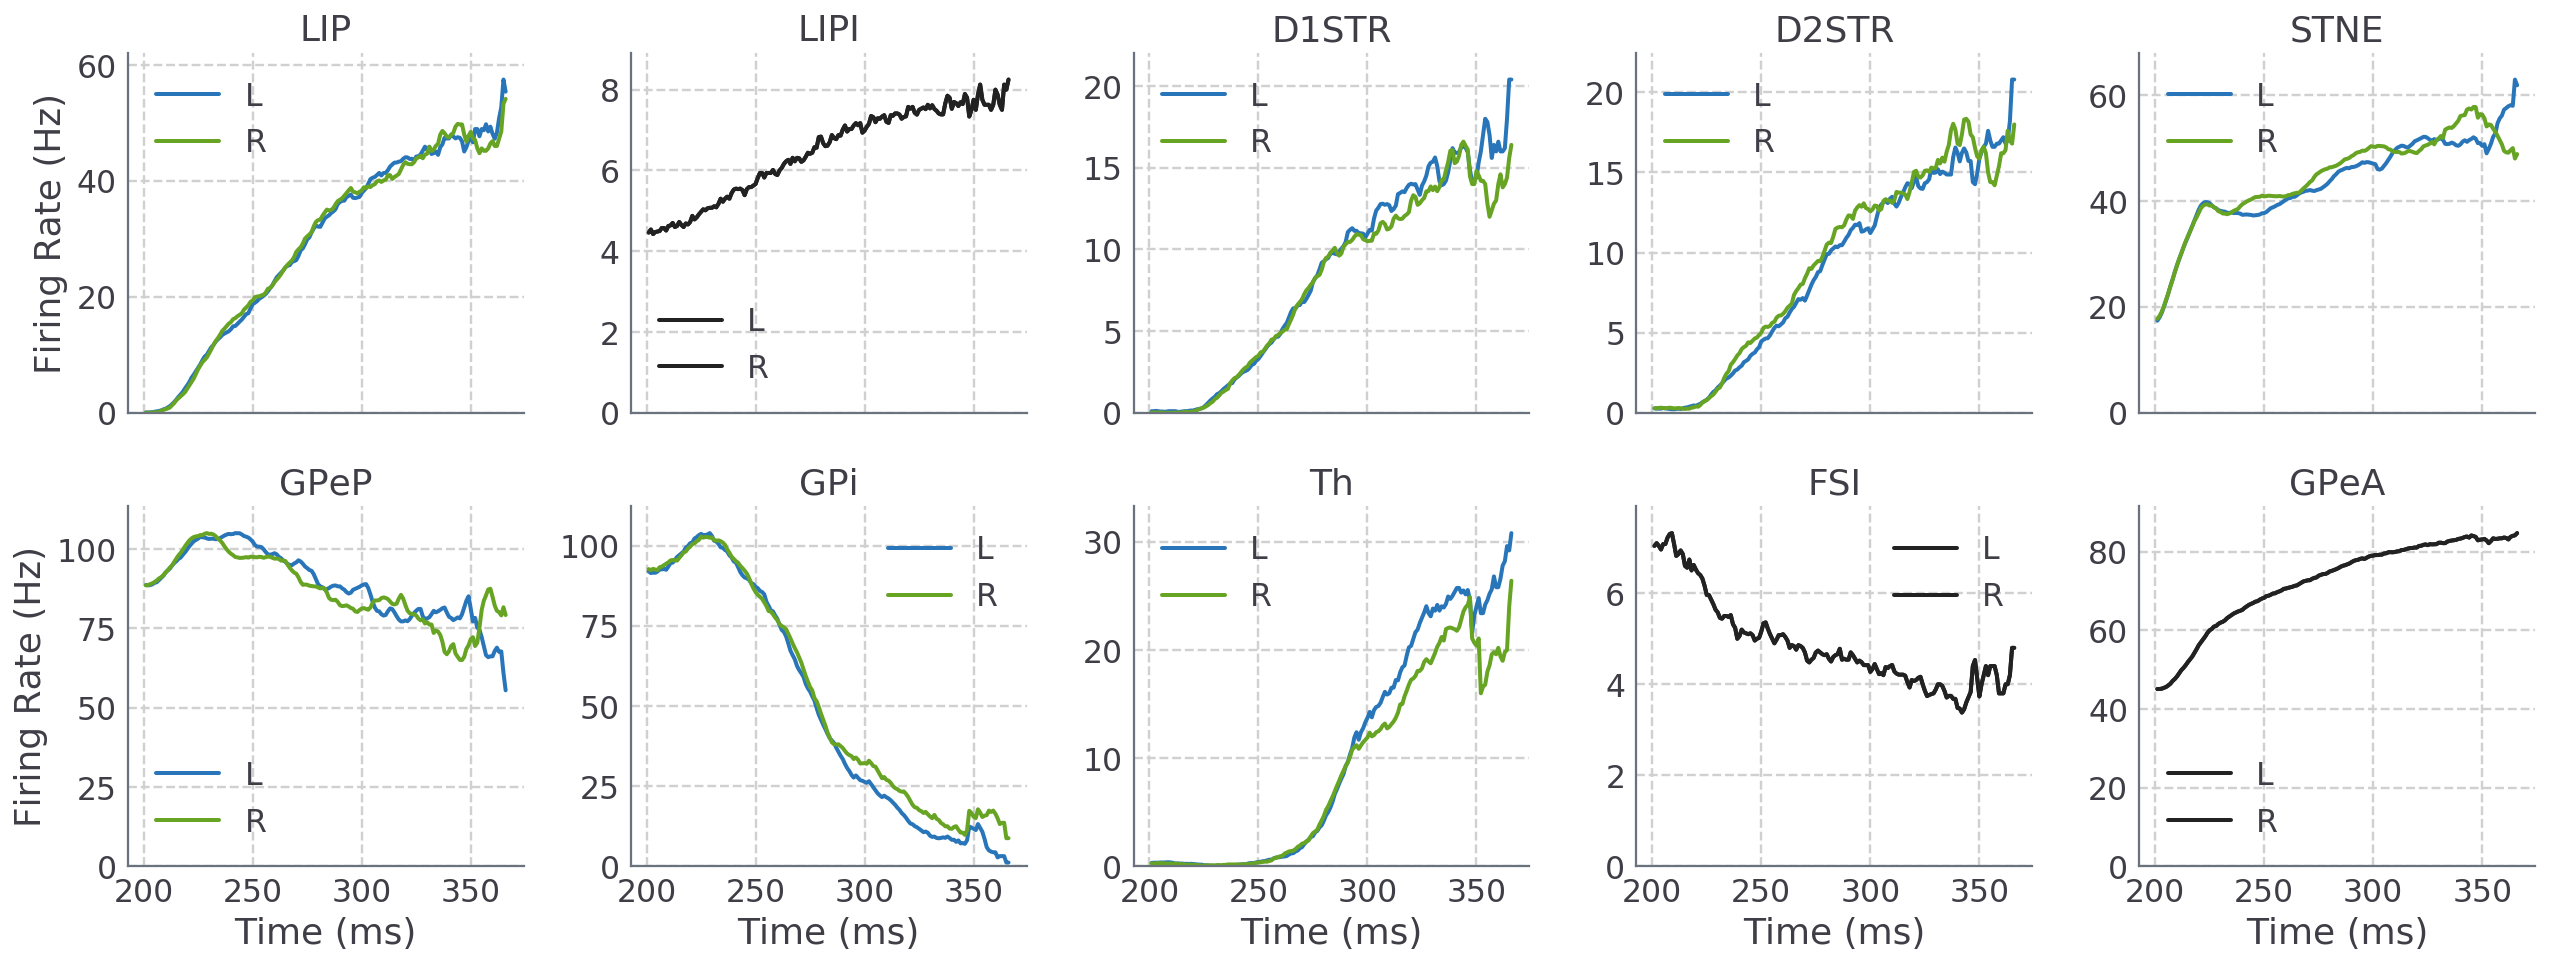

In [139]:
spikedfWeak2 = get_firing_rates(resWeak[0])
avgRatesWeak2 = get_mean_firing_rates(spikedfWeak2)
axes = plot_spikes(avgRatesWeak2, start=200)
f = plt.gcf()

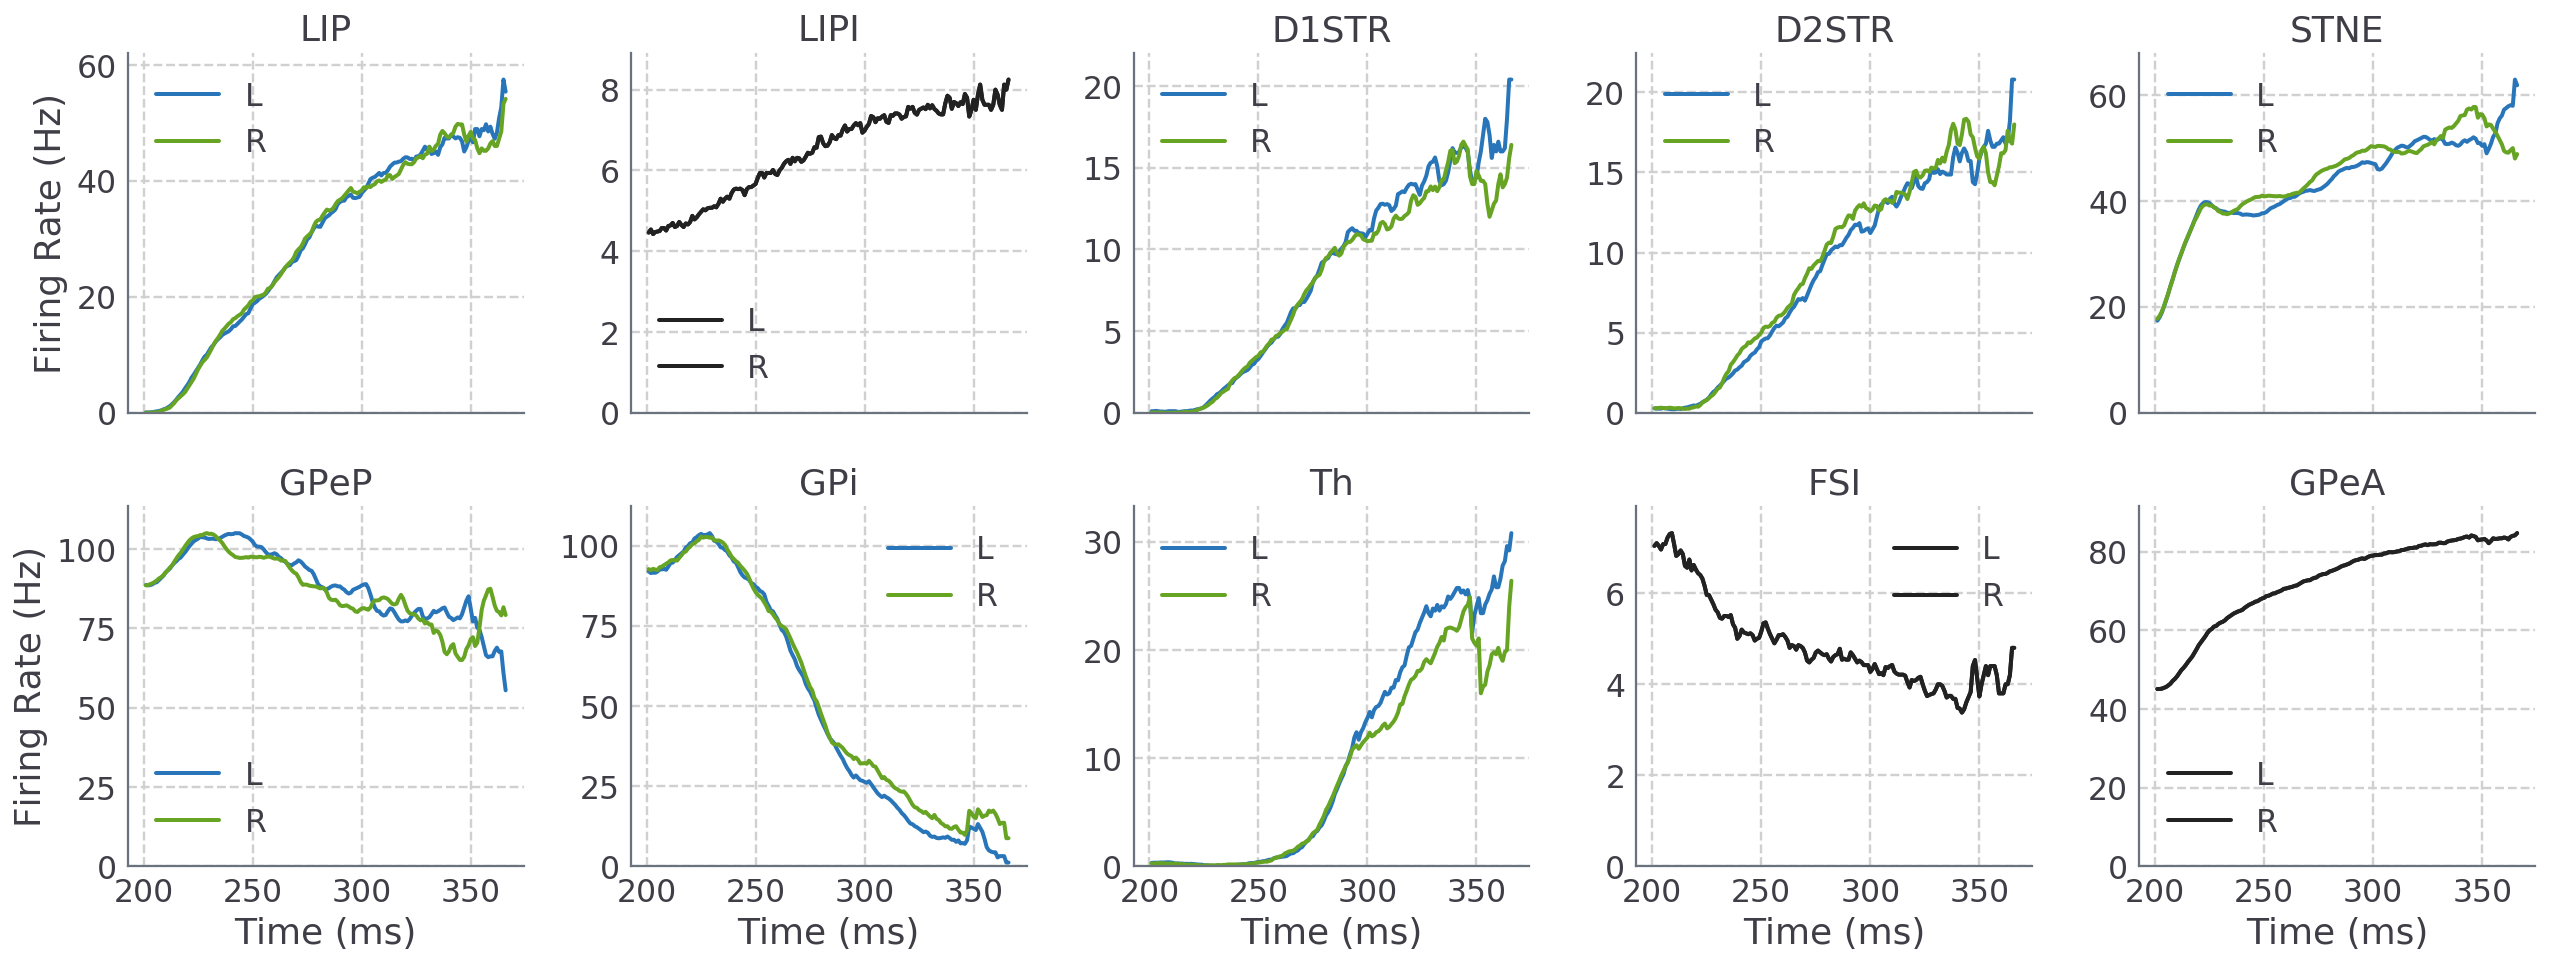

In [135]:
resWeak, behavdfWeak, spikedfWeak = run_cbgt_simulations(preset=presetWeak, savedir=saveWeak, cond='weak', ntrials=20, Start=200, popscale=0.5, BaseStim=[1.6], WrongStim=[3.75], RightStim=[3.75], Dynamic=[30.0], Choices=2, CxSTR=1., GPiExtEff=6., STNExtEff=1.65, STNExtFreq=4.7)

spikedfWeak = get_firing_rates(resWeak[0])
avgRatesWeak = get_mean_firing_rates(spikedfWeak)
axes = plot_spikes(avgRatesWeak, start=200)
f = plt.gcf()

f.savefig(os.path.join(saveWeak, 'avg_fr_weak.png'), dpi=500)
behavdfWeak.to_csv(os.path.join(saveWeak, 'bgNet_behavdf_weak.csv'), index=False)
spikedfWeak.to_csv(os.path.join(saveWeak, 'bgNet_spikedf_weak.csv'), index=False)

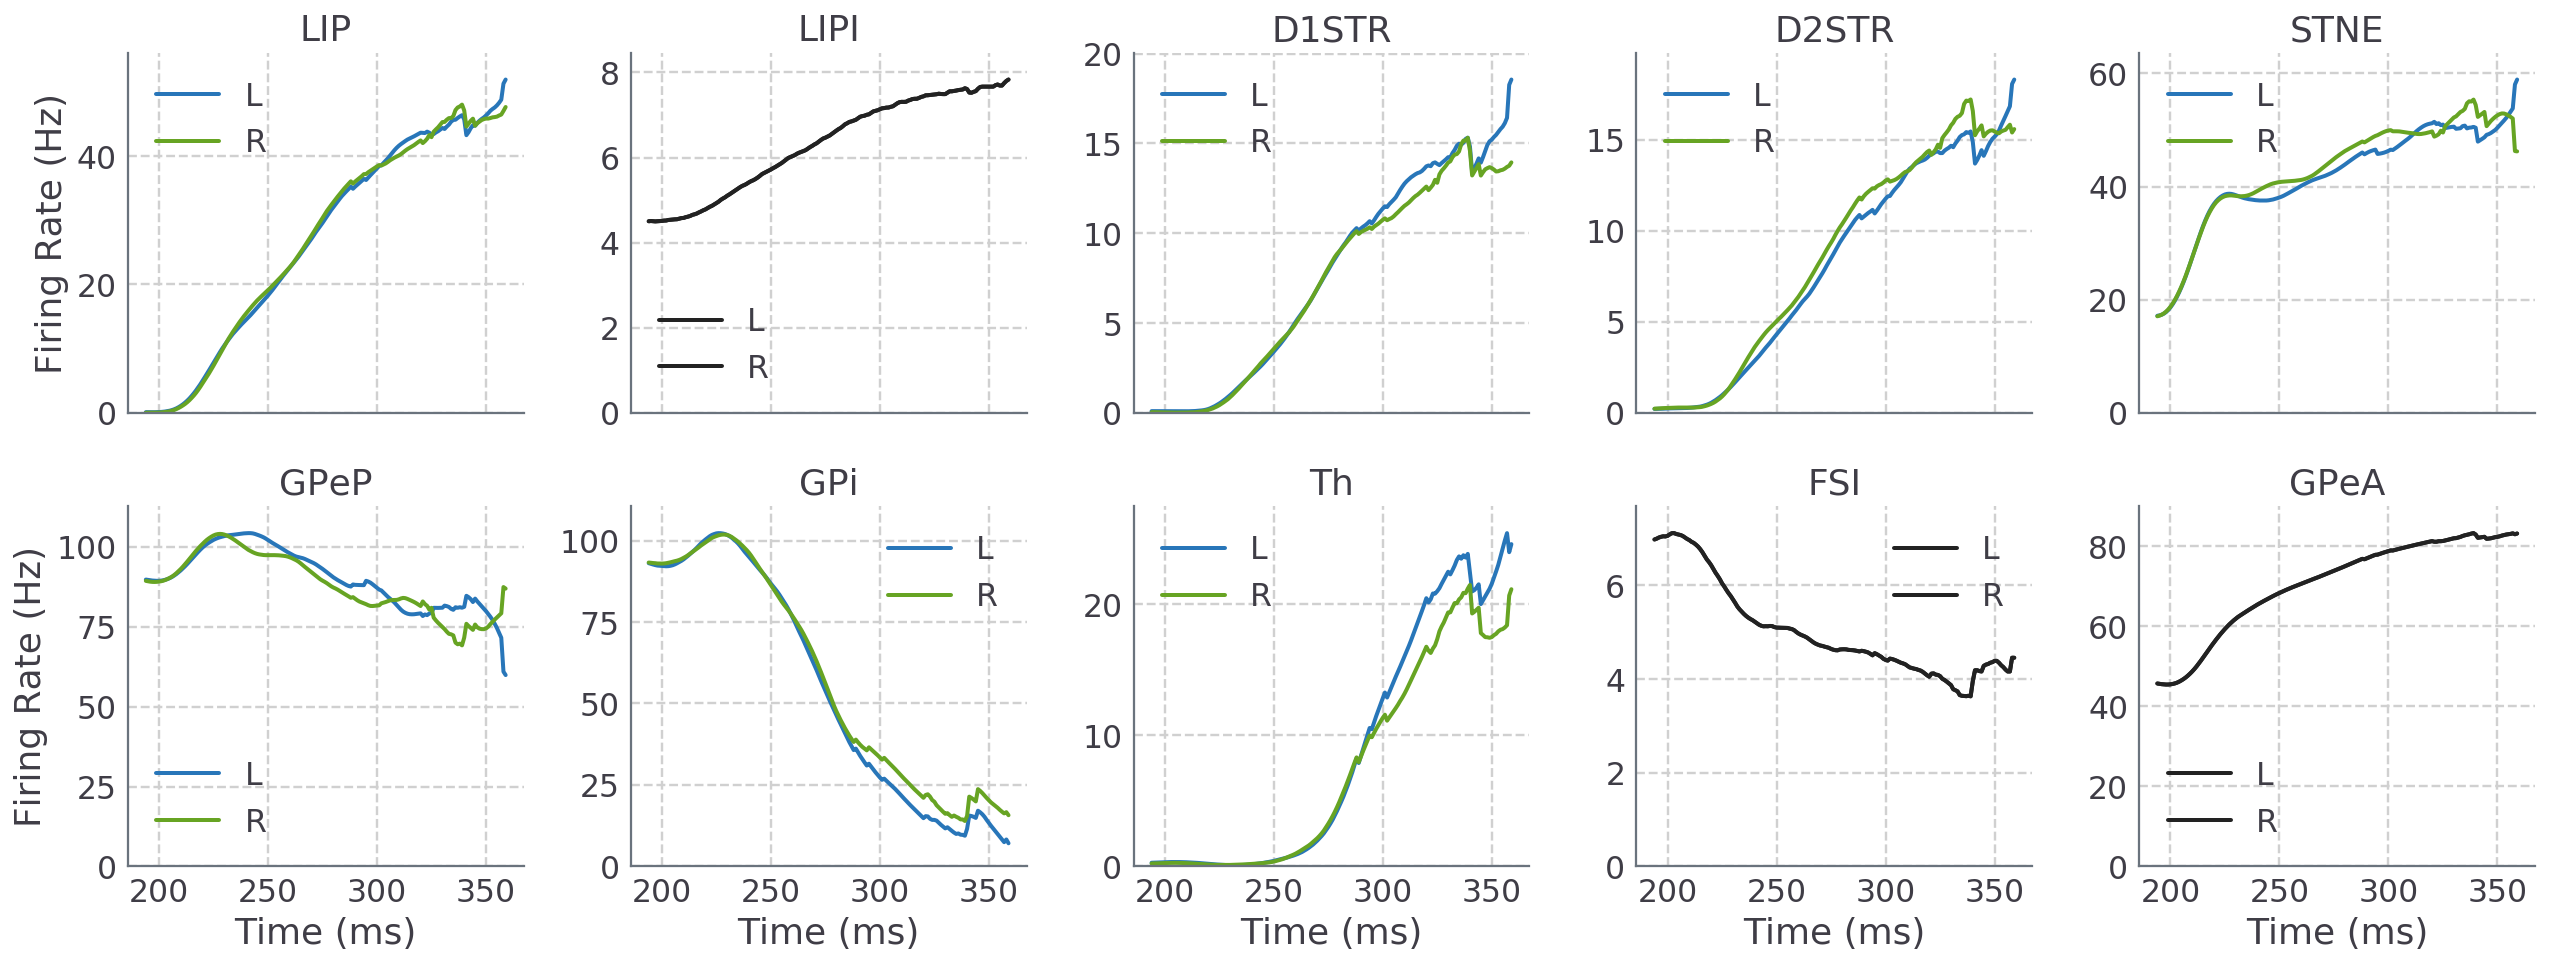

In [222]:
spikedfWeak, avgRatesWeak = save_and_plot(resWeak[0], behavdfWeak, cond='weak', savedir=saveWeak, window=15, Start=200, trials=[1,2], getdfs=True)

In [ ]:
f.savefig(os.path.join(saveWeak, 'avg_fr_weak.png'), dpi=500)
behavdfWeak.to_csv(os.path.join(saveWeak, 'bgNet_behavdf_weak.csv'), index=False)
spikedfWeak.to_csv(os.path.join(saveWeak, 'bgNet_spikedf_weak.csv'), index=False)

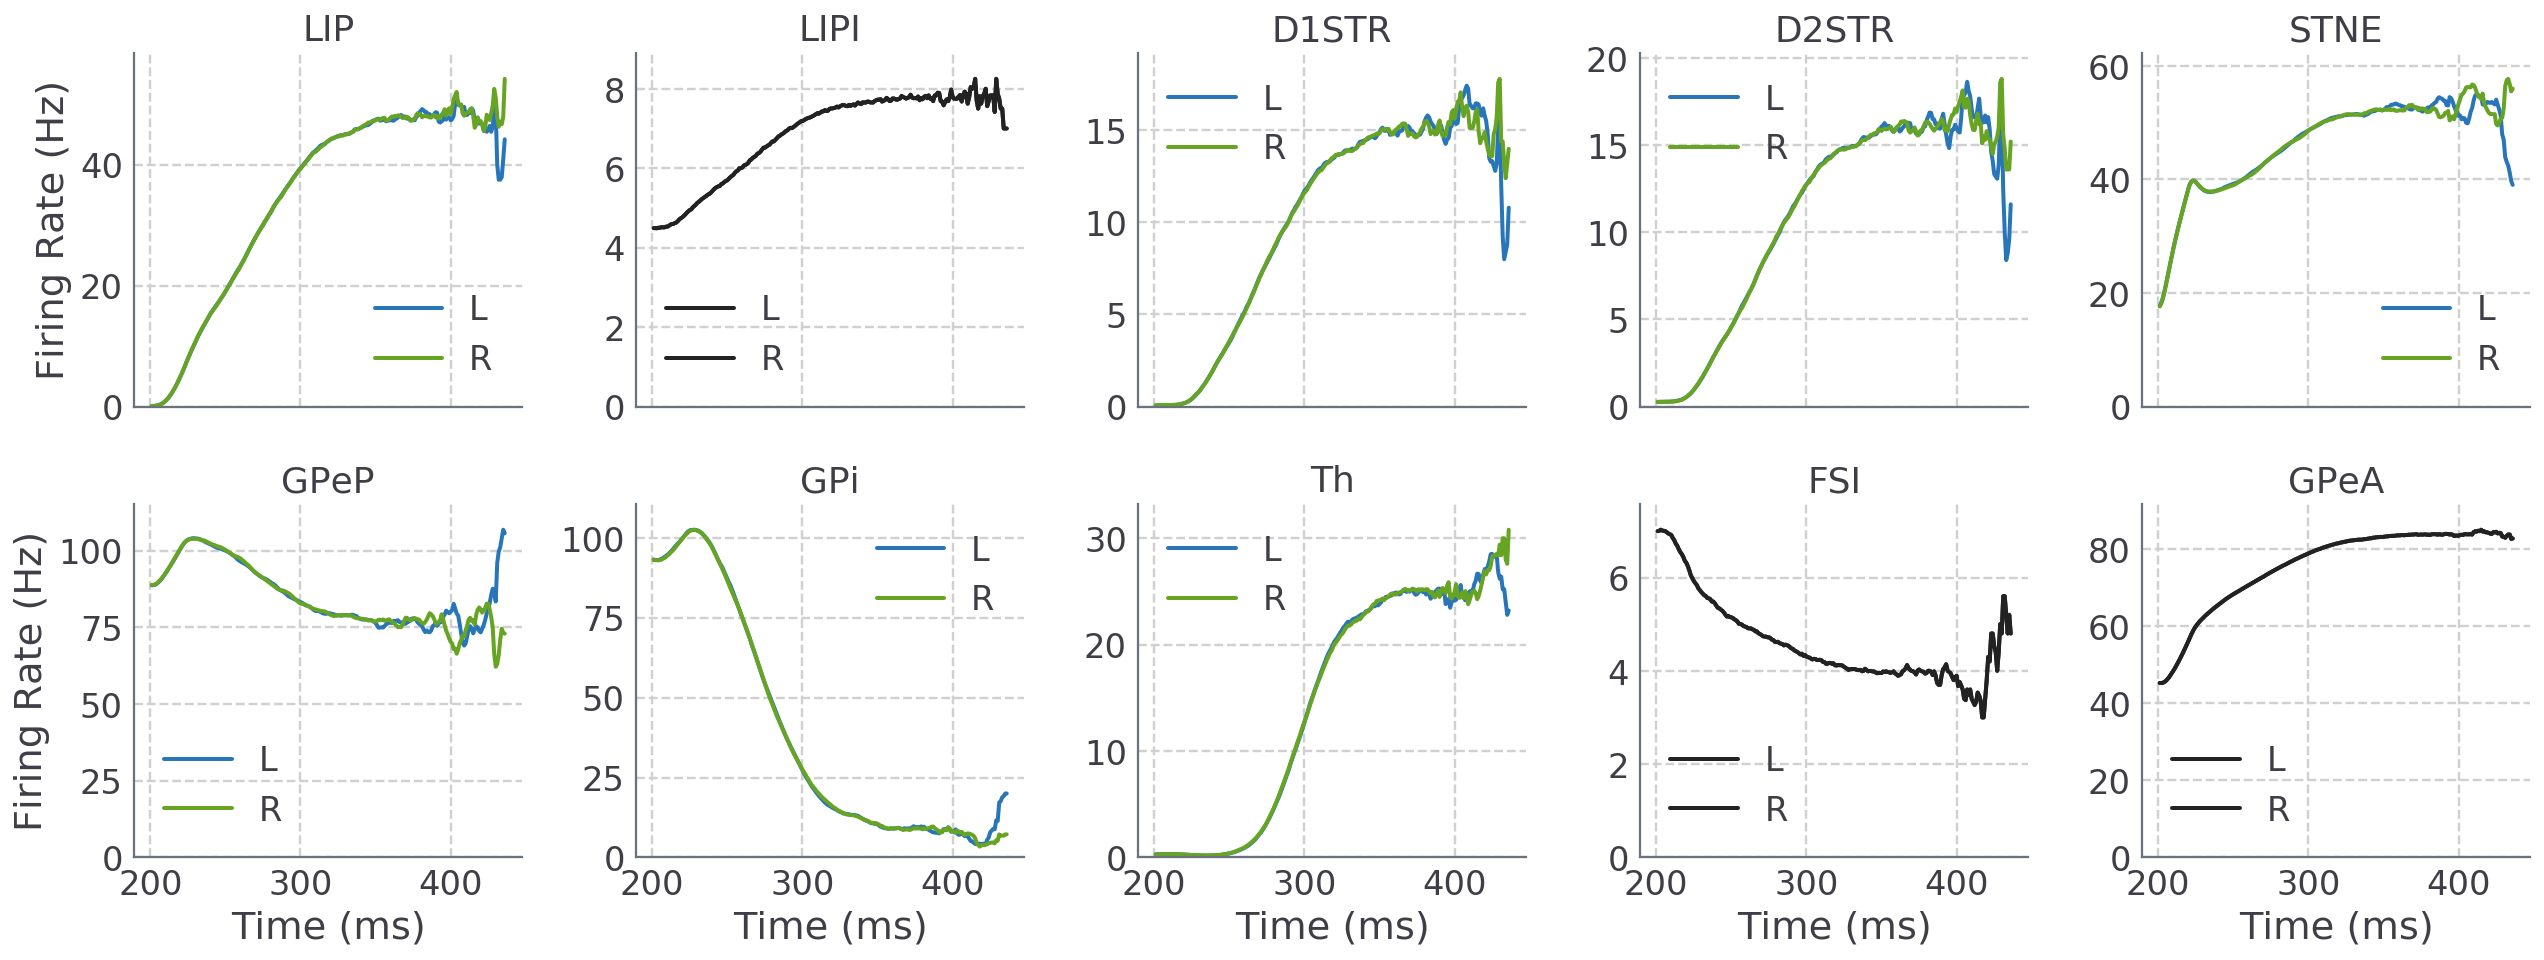

In [5]:
preset = presetWeak
ng.setDirectory(saveWeak)
sweepcount = ng.configureSweep(experiment='mc', Start=200, popscale=0.5, BaseStim=[1.6], WrongStim=[3.75], RightStim=[3.75], Dynamic=[30.0], Choices=2, CxSTR=1., GPiExtEff=6., STNExtEff=1.65, STNExtFreq=4.7, preset=presetWeak)

ng.compileAndRunSweep(ntrials, 0, sweepcount)
outdir = ng.getDirectory()
popmax = 0
continueLooking = True

sleep(5)
while continueLooking:
    
    fnames = np.asarray([fn.split('.')[0].split('popfreqs')[-1] for fn in os.listdir(outdir)])
    tlist = np.sort([int(fn) for fn in fnames if fn.isnumeric()])
    
    if tlist == []: continue
    else: popmax = np.max(tlist)
        
    if popmax < (ntrials-1):
        continue
    
    resWeak = ng.readAllTrialResults(ntrials,0,sweepcount)
    decisionsWeak, behavdfWeak = analyze_network_behavior(resWeak)

    if np.all([tinfo['time'] for tinfo in decisionsWeak[0]]):
        continueLooking=False
    else:
        continue
    return results, decisions, behavdf
    avgdfWeak = get_avg_spikedf(resWeak[0]).reset_index(drop=True)        
    axes = plot_spikes(avgdfWeak, start=200)
    f = plt.gcf()
    f.savefig(os.path.join(savedir, 'avg_fr_weak.png'), dpi=500)
    behavdfWeak['rt'] = behavdfWeak.rt.values + 200
    behavdfWeak.insert(0, 'cond', 'weak')
    behavdfWeak.insert(1, 'subj_idx', 1)
    behavdfWeak['response'] = behavdfWeak.acc.values
    behavdfWeak.to_csv(os.path.join(savedir, 'bgNet_behavdf_weak.csv'), index=False)
    avgdfWeak.to_csv(os.path.join(savedir, 'bgNet_spikedf_weak.csv'), index=False)

# Moderate $^{w_D}/_{w_I}$

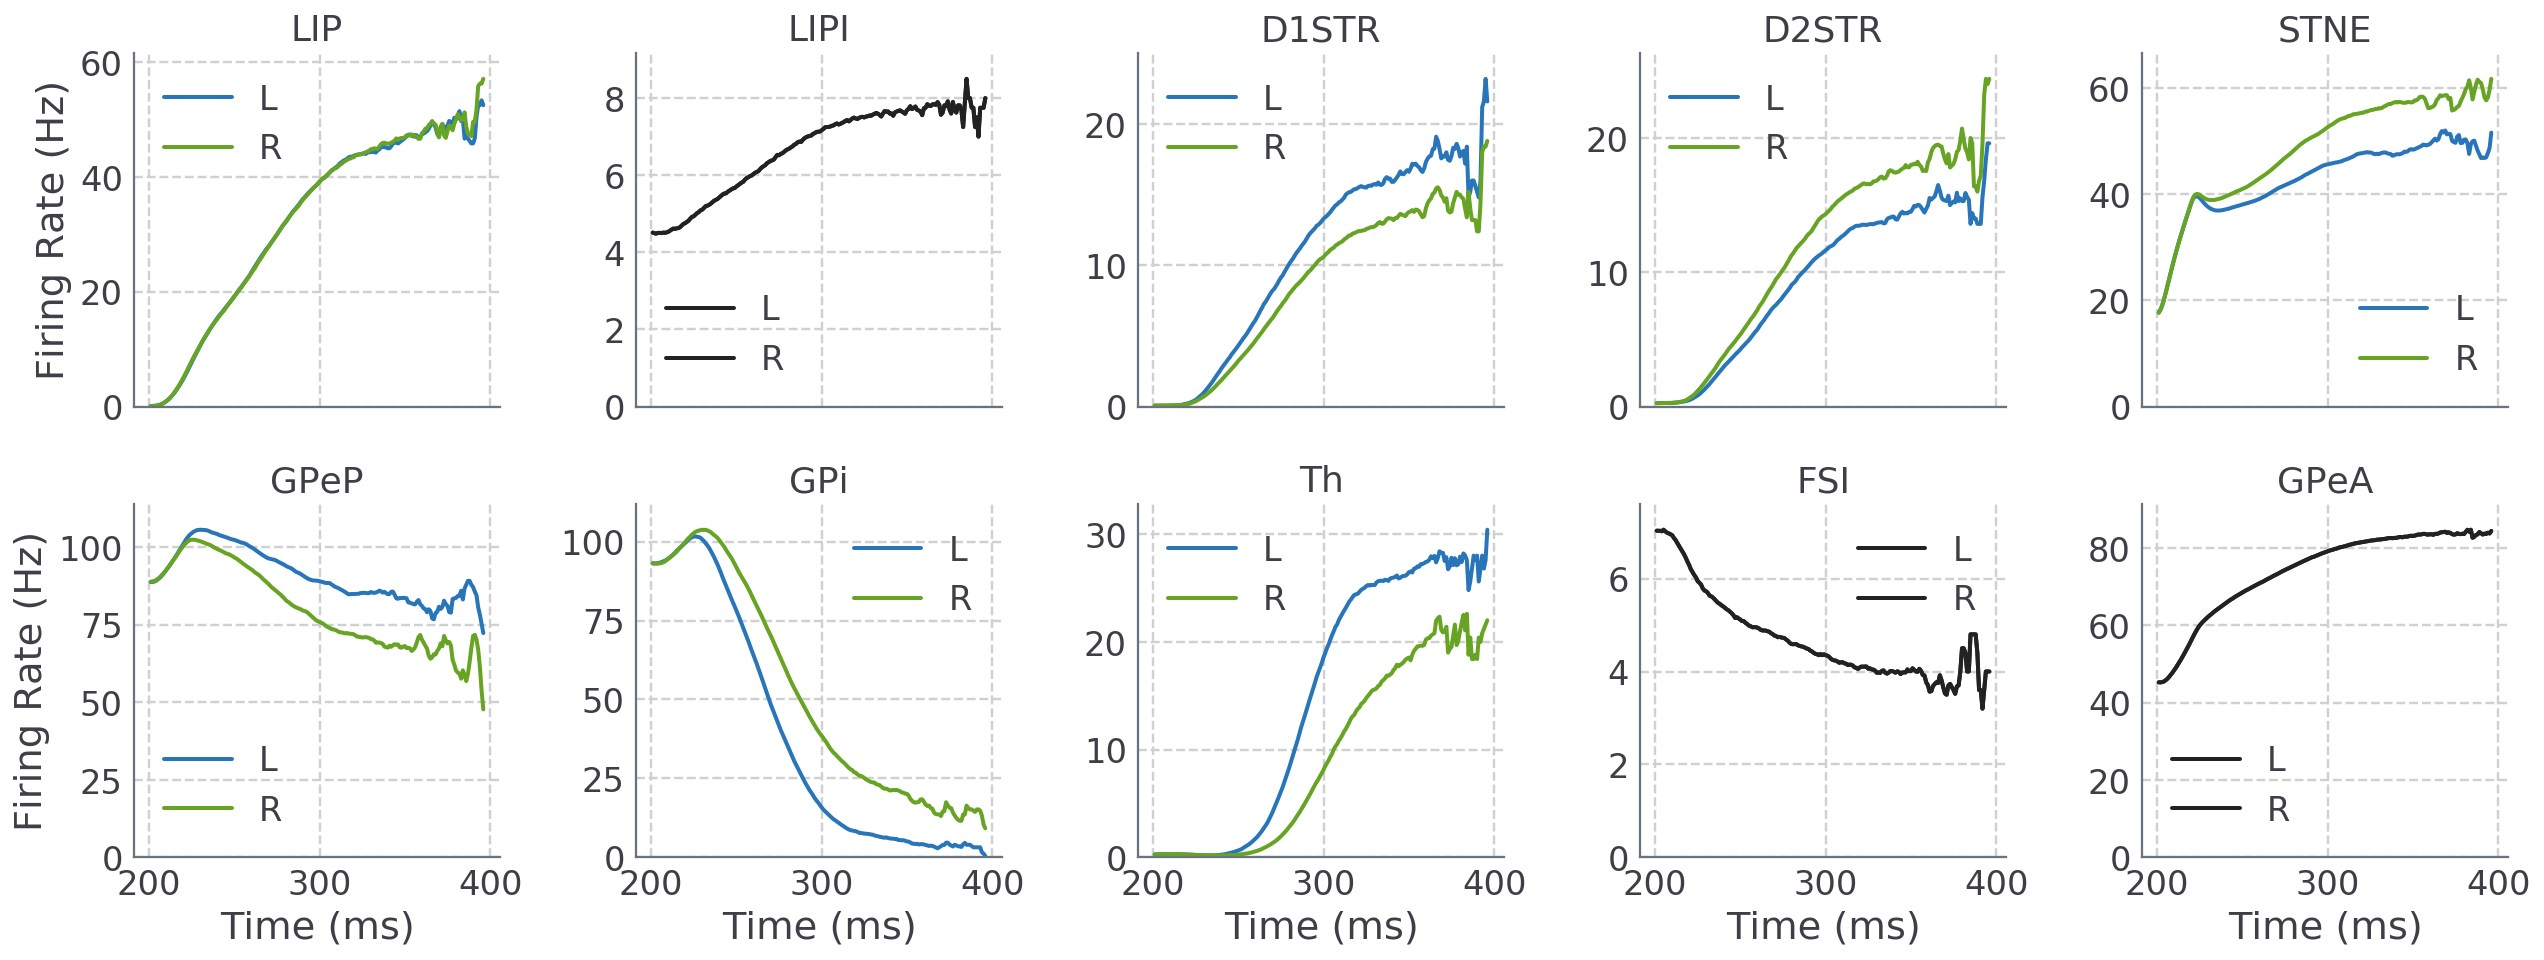

In [6]:
preset = presetMod
ng.setDirectory(saveMod)
sweepcount = ng.configureSweep(experiment='mc', Start=200, popscale=0.5, BaseStim=[1.6], WrongStim=[3.75], RightStim=[3.75], Dynamic=[30.0], Choices=2, CxSTR=1., GPiExtEff=6., STNExtEff=1.65, STNExtFreq=4.7, preset=presetMod)

ng.compileAndRunSweep(ntrials, 0, sweepcount)

outdir = ng.getDirectory()
popmax = 0
continueLooking = True
sleep(5)

while continueLooking:
    
    fnames = np.asarray([fn.split('.')[0].split('popfreqs')[-1] for fn in os.listdir(outdir)])
    tlist = np.sort([int(fn) for fn in fnames if fn.isnumeric()])
    
    if tlist == []: continue
    else: popmax = np.max(tlist)
    if popmax < (ntrials-1):
        continue
    
    resMod = ng.readAllTrialResults(ntrials,0,sweepcount)
    decisionsMod, behavdfMod = analyze_network_behavior(resMod)

    if np.all([tinfo['time'] for tinfo in decisionsMod[0]]):
        continueLooking=False
    else:
        continue
    
    avgdfMod = get_avg_spikedf(resMod[0]).reset_index(drop=True)    
    axes = plot_spikes(avgdfMod, start=200)
    f = plt.gcf()
    f.savefig(os.path.join(savedir, 'avg_fr_mod.png'), dpi=500)
    behavdfMod['rt'] = behavdfMod.rt.values + 200
    behavdfMod.insert(0, 'cond', 'mod')
    behavdfMod.insert(1, 'subj_idx', 1)
    behavdfMod['response'] = behavdfMod.acc.values
    behavdfMod.to_csv(os.path.join(savedir, 'bgNet_behavdf_mod.csv'), index=False)
    avgdfMod.to_csv(os.path.join(savedir, 'bgNet_spikedf_mod.csv'), index=False)

# High $^{w_D}/_{w_I}$

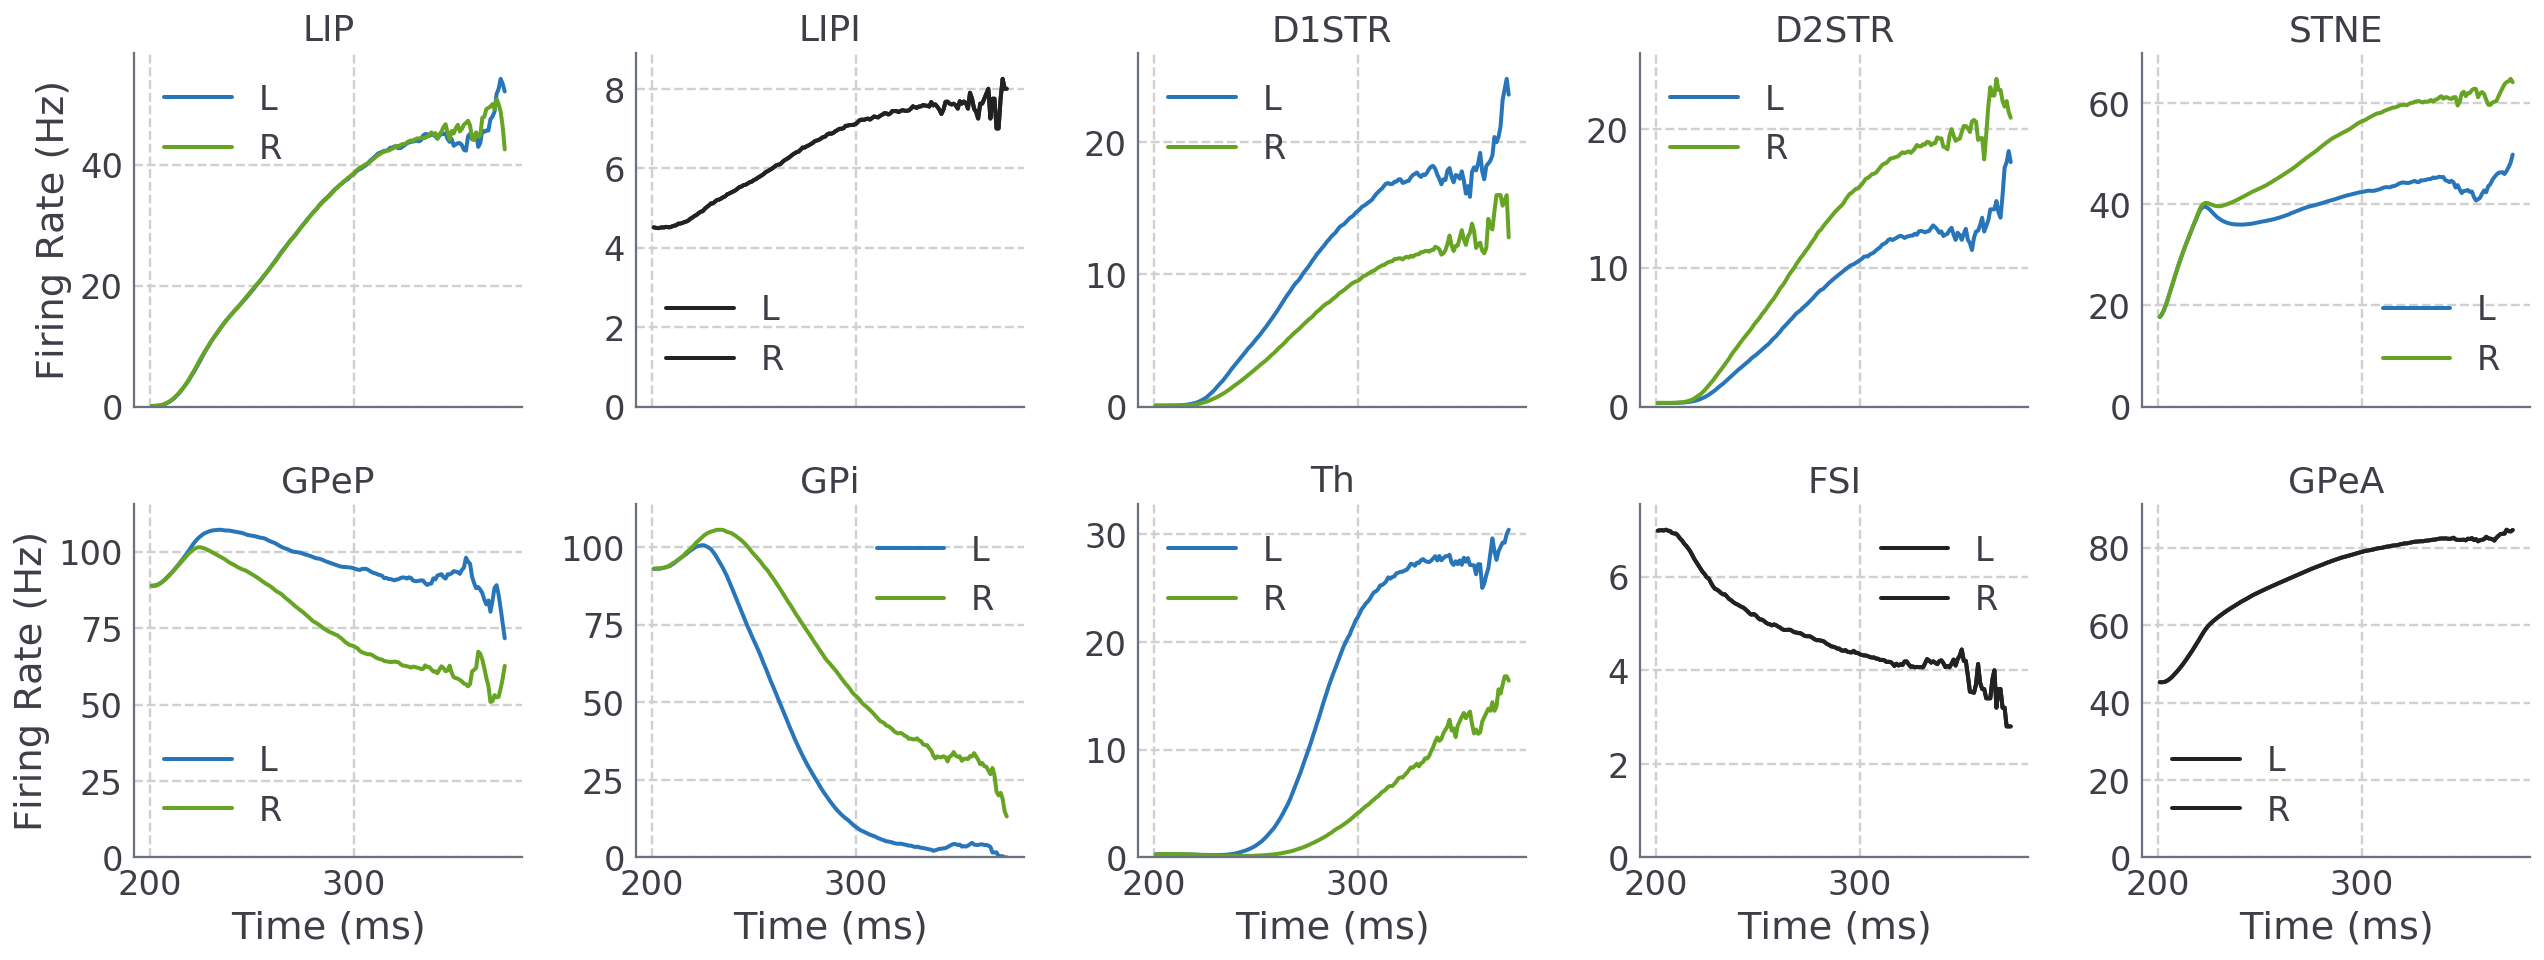

In [7]:
preset = presetHi
ng.setDirectory(saveHi)
sweepcount = ng.configureSweep(experiment='mc', Start=200, popscale=0.5, BaseStim=[1.6], WrongStim=[3.75], RightStim=[3.75], Dynamic=[30.0], Choices=2, CxSTR=1., GPiExtEff=6., STNExtEff=1.65, STNExtFreq=4.7, preset=presetHi)

ng.compileAndRunSweep(ntrials, 0, sweepcount)

outdir = ng.getDirectory()
popmax = 0
continueLooking = True

sleep(5)
while continueLooking:
    
    fnames = np.asarray([fn.split('.')[0].split('popfreqs')[-1] for fn in os.listdir(outdir)])
    tlist = np.sort([int(fn) for fn in fnames if fn.isnumeric()])
    
    if tlist == []: continue
    else: popmax = np.max(tlist)
        
    if popmax < (ntrials-1):
        continue
    
    resHi = ng.readAllTrialResults(ntrials,0,sweepcount)
    decisionsHi, behavdfHi = analyze_network_behavior(resHi)

    if np.all([tinfo['time'] for tinfo in decisionsHi[0]]):
        continueLooking=False
    else:
        continue
    
    avgdfHi = get_avg_spikedf(resHi[0]).reset_index(drop=True)    
    axes = plot_spikes(avgdfHi, start=200)
    f = plt.gcf()
    f.savefig(os.path.join(savedir, 'avg_fr_high.png'), dpi=500) 
    behavdfHi['rt'] = behavdfHi.rt.values + 200
    behavdfHi.insert(0, 'cond', 'hi')
    behavdfHi.insert(1, 'subj_idx', 1)
    behavdfHi['response'] = behavdfHi.acc.values
    behavdfHi.to_csv(os.path.join(savedir, 'bgNet_behavdf_hi.csv'), index=False)
    avgdfHi.to_csv(os.path.join(savedir, 'bgNet_spikedf_hi.csv'), index=False)

# Behav Analysis

In [258]:
savedir='/home/kyle/Dropbox/bgFeb18'

'/home/kyle/Dropbox/bgFeb18'

In [234]:
behavdf2_fpath = os.path.join(savedir, 'cbgt_behavdf_all2.csv')
df2 = pd.concat([behavdfBal, behavdfWeak, behavdfMod, behavdfHi])
df2 = df2.reset_index(drop=True)
df2.to_csv(behavdf2_fpath, index=False)

behavdf_fpath = os.path.join(savedir, 'cbgt_behavdf_all.csv')
df = pd.concat([behavdfBal, behavdfMod, behavdfHi])
df = df.reset_index(drop=True)
df.to_csv(behavdf_fpath, index=False)

In [238]:
df1 = pd.read_csv(behavdf_fpath)
df2 = pd.read_csv(behavdf2_fpath)

In [253]:
df = df1.copy()

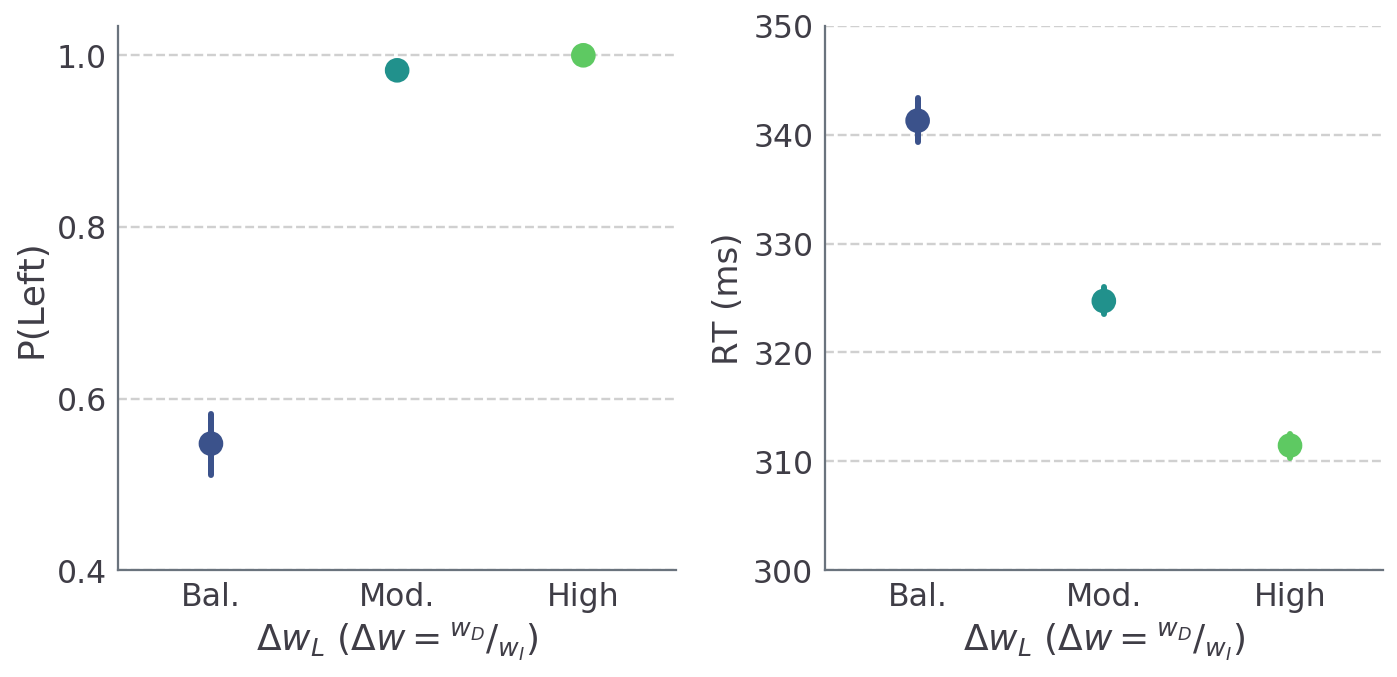

In [256]:
sns.set(font='Arial')
splot.style(theme='safari-day', grid=True, spines=True, fscale=1.5, figsize=(7,5))
conds = ['bal', 'mod', 'hi']
cnames = ['Bal.', "Mod.", "High"]
# conds = ['bal', 'weak', 'mod', 'hi']
# cnames = ['Bal.', 'Weak', "Mod.", "High"]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1 = sns.pointplot(x='cond', y='acc', data=df, palette="viridis", order=conds, scale=1.75, errwidth=3, ax=ax1)
ax2 = sns.pointplot(x='cond', y='rt', data=df[df.acc==1], palette="viridis", order=conds, scale=1.75, errwidth=3, ax=ax2)

for ax in [ax1, ax2]:
    ax.set_xticklabels(cnames)#, fontsize=14)
    ax.set_xlabel('$\Delta w_L \\ (\Delta w = ^{w_D}/_{w_I})$')#, fontsize=16)
    sns.despine(ax=ax)
ax1.set_yticks([.4, .6, .8, 1.])
ax1.set_yticklabels([.4,.6,.8, 1.])#, fontsize=14)
ax1.set_ylabel('P(Left)')#, fontsize=17)
ax2.set_yticks(np.arange(300, 360, 10))
ax2.set_yticklabels(np.arange(300, 360, 10))#, fontsize=14)
ax2.set_ylabel('RT (ms)', fontsize=17)
plt.tight_layout() 
# f.savefig('/home/kyle/Dropbox/phasic_3conds_meanAccRT.png', dpi=400)

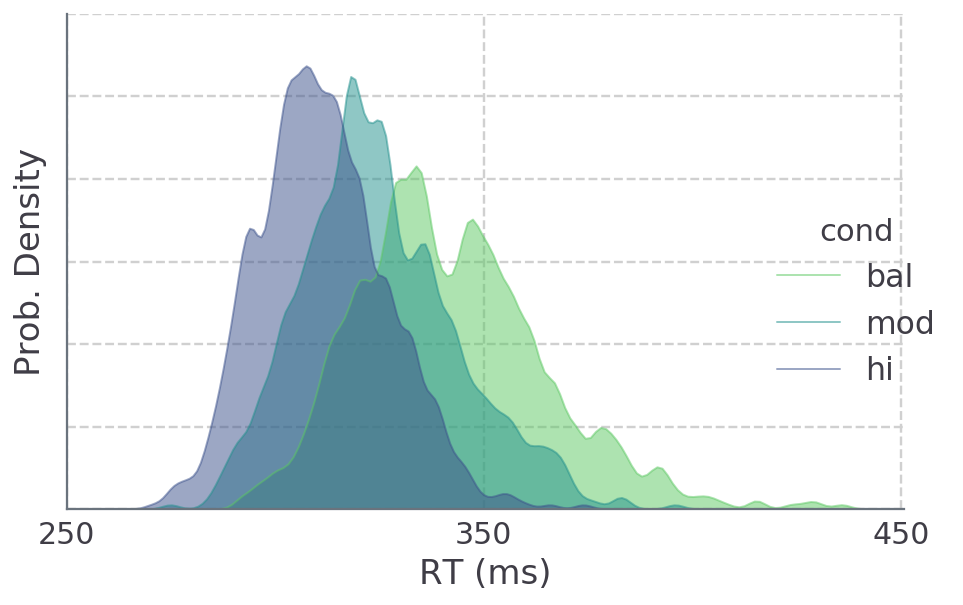

In [257]:
gf = sns.FacetGrid(df, hue='cond', palette='viridis_r', size=4.5, aspect=1.24, sharey=True)
gf.map(sns.kdeplot, 'rt', shade=True, linewidth=1., alpha=.5, bw=2.)
gf.add_legend()
gf.ax.set_ylim(0,.03)
_=gf.ax.set_yticklabels([])
gf.ax.set_xticks([250, 350, 450])
gf.ax.set_xticklabels([250, 350, 450], fontsize=15)
gf.ax.set_ylabel('Prob. Density', fontsize=17)
gf.ax.set_xlabel('RT (ms)', fontsize=17)
sns.despine()
plt.tight_layout()
gf.fig.savefig('/home/kyle/Dropbox/phasic_3conds_RTdists.png', dpi=400)